# Imports, Settings, and Globals

In [4]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from pylab import *
from keras.callbacks import LearningRateScheduler
from keras import models
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.vgg19 import VGG19
import itertools
from sklearn.metrics import confusion_matrix
from keras import optimizers
from PIL import Image
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# VGG19 with Initial Parameters 

In [5]:
# Controling Learning Rate 
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
        def schedule(epoch):
            return initial_lr * (decay_factor ** np.floor(epoch / step_size))
        return LearningRateScheduler(schedule)

In [3]:
# Define VGG19 with initial parameters
vgg_conv = VGG19(weights='/kaggle/input/vgg-19-wts/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))
vgg_conv.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### We are freezing all the layers of the pre-trained model and adding 2xDense layers and 1XSigmoid layer for binary classification afterwards:  

In [4]:
model = models.Sequential()

# Freezing layers to stop them from learning (since its been trained on 'ImageNet')
for layer in vgg_conv.layers:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

# Adding custon Dense layers for learning from our dataset and sigmoid layer for binary classification 
model.add(vgg_conv)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              # loss="mean_squared_error",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Get Model Summary
model.summary()


<keras.engine.input_layer.InputLayer object at 0x7fbb3fe14490> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fbae889bed0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fbae889bf50> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fbae3fd3150> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fbad879bc10> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fbad87ab890> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fbad87beed0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fbad87be8d0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fbad87b9410> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fbad87c82d0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fbad87c5350> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fbad87d3090> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fbad8761590> False
<keras.layers.convolut

In [5]:
# Initializing learning rate schedule
lr_sched = step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=2)

In [6]:
# Reading raw data using ImageDatagenerator for Train and Valid data
TRAINING_DIR = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train'
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,target_size=(224,224),batch_size=32,class_mode='binary')

VALIDATION_DIR = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid'
validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,target_size=(224,224),batch_size=32,class_mode='binary')


Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [7]:
# Reading raw data using ImageDatagenerator for Test data 
TEST_DIR = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test'
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=(224,224),batch_size=32,class_mode='binary', shuffle=False )

Found 20000 images belonging to 2 classes.


In [8]:
# Calculating Train and Valid Accuracies on Training data:
history = model.fit(
      train_generator,
      steps_per_epoch=500,  # Number of images = batch_size * steps
      epochs=9,
      validation_data=validation_generator,
      validation_steps=10,
      callbacks=[lr_sched]
)

Epoch 1/9
500/500 [==============================] - 174s 320ms/step - loss: 0.9472 - accuracy: 0.7549 - val_loss: 0.4484 - val_accuracy: 0.8062 - lr: 0.0010
Epoch 2/9
500/500 [==============================] - 144s 287ms/step - loss: 0.3827 - accuracy: 0.8357 - val_loss: 0.4139 - val_accuracy: 0.8219 - lr: 0.0010
Epoch 3/9
500/500 [==============================] - 134s 267ms/step - loss: 0.3203 - accuracy: 0.8652 - val_loss: 0.3421 - val_accuracy: 0.8562 - lr: 7.5000e-04
Epoch 4/9
500/500 [==============================] - 123s 245ms/step - loss: 0.3009 - accuracy: 0.8781 - val_loss: 0.2771 - val_accuracy: 0.9000 - lr: 7.5000e-04
Epoch 5/9
500/500 [==============================] - 115s 230ms/step - loss: 0.2624 - accuracy: 0.8950 - val_loss: 0.2833 - val_accuracy: 0.8844 - lr: 5.6250e-04
Epoch 6/9
500/500 [==============================] - 107s 214ms/step - loss: 0.2574 - accuracy: 0.8941 - val_loss: 0.2501 - val_accuracy: 0.9062 - lr: 5.6250e-04
Epoch 7/9
500/500 [=================

In [9]:
# Saving trained model
model.save('vgg19.h5')

# Evaluating the Model on Test Dataset by calculating Accuracy and F1-Score:

In [17]:
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

625/625 [==============================] - 114s 182ms/step - loss: 0.2850 - accuracy: 0.8870
Test loss: 0.28501665592193604
Test accuracy: 0.8870499730110168


In [11]:
print(model.metrics_names)

['loss', 'accuracy']


In [12]:
THRESHOLD = 0.5
test_predict_probability = model.predict(test_generator)
test_predict = np.where(test_predict_probability > THRESHOLD, 1, 0)

test_predict

625/625 [==============================] - 113s 181ms/step


array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

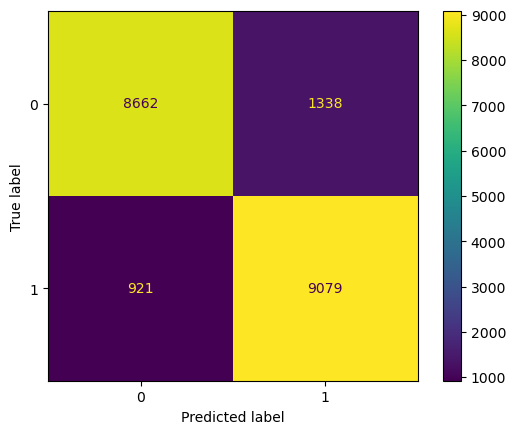

In [14]:
cm = confusion_matrix(test_generator.classes, test_predict, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()
plt.show()

In [16]:
f1_score(test_generator.classes, test_predict)

0.8893569084586375

# Evaluating the Model on Train and Validation Datasets by calculating F1-Score:

In [3]:
import tensorflow as tf
new_model = tf.keras.models.load_model('/kaggle/working/vgg19.h5')

In [14]:
TRAINING_DIR = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train'
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,target_size=(224,224),batch_size=32,class_mode='binary', shuffle=False)

VALIDATION_DIR = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid'
validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,target_size=(224,224),batch_size=32,class_mode='binary', shuffle=False);

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [15]:
THRESHOLD = 0.5
train_predict_probability = new_model.predict(train_generator)
train_predict = np.where(train_predict_probability > THRESHOLD, 1, 0)

train_predict

3125/3125 [==============================] - 568s 182ms/step


array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

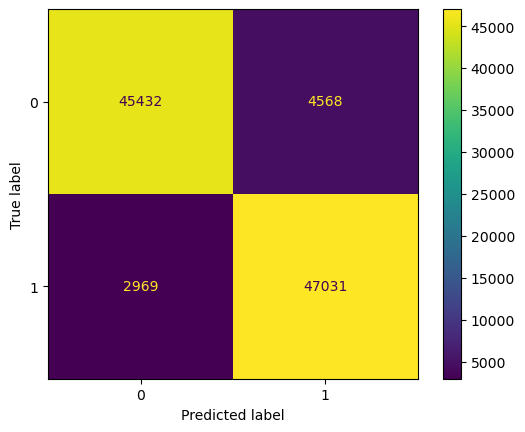

In [16]:
cm = confusion_matrix(train_generator.classes, train_predict, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()
plt.show()

In [17]:
# F1 Score
f1_score(train_generator.classes, train_predict)

0.9258161989783366

In [18]:
THRESHOLD = 0.5
val_predict_probability = new_model.predict(validation_generator)
val_predict = np.where(val_predict_probability > THRESHOLD, 1, 0)

val_predict

625/625 [==============================] - 114s 182ms/step


array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [1]])

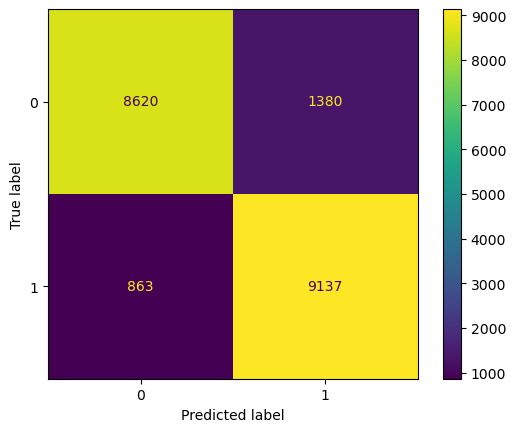

In [19]:
cm = confusion_matrix(validation_generator.classes, val_predict, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()
plt.show()

In [20]:
# F1 Score
f1_score(validation_generator.classes, val_predict)

0.8906760247599552